In [3]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Other modules (if needed)

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Standard libraries
import os
import pandas as pd
import glob
from typing import List


def load_bb_simulation_data(
    n: int,
    T: int,
    p: float,
    data_dir: str = "../../simulations/data/bb_circuit_iter30_minsum_lsd0",
) -> pd.DataFrame:
    """
    Load BB code circuit simulation data from feather files and combine them for a specific (n, p) pair.

    Parameters
    ----------
    n : int
        Number of qubits in the BB code
    T : int
        Number of rounds
    p : float
        Physical error rate
    data_dir : str
        Directory path containing the simulation data files, defaults to "../simulations/data/bb_circuit_iter30_minsum_lsd0"

    Returns
    -------
    combined_df : pd.DataFrame
        Combined DataFrame containing all simulation data for the specified (n, p)
    """
    # Ensure the directory exists
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Data directory not found: {data_dir}")

    # Pattern to match files for the specific (n, p) pair
    pattern = f"n{n}_T{T}_p{p}_*.feather"
    file_paths = glob.glob(os.path.join(data_dir, pattern))

    if not file_paths:
        raise ValueError(f"No data files found for n={n}, p={p} in {data_dir}")

    print(f"Loading data for n={n}, T={T}, p={p} from {len(file_paths)} files...")

    # Load and concatenate all files for this (n, p) pair
    dfs: List[pd.DataFrame] = []
    for file_path in file_paths:
        try:
            df = pd.read_feather(file_path)
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    if not dfs:
        raise ValueError(f"Failed to load any data for n={n}, p={p}")

    # Combine all dataframes for this (n, p) pair
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"  → Combined {len(dfs)} files with total {len(combined_df)} rows")

    return combined_df

In [13]:
from src.ldpc_post_selection.build_circuit import get_BB_distance

n = 144
T = get_BB_distance(n)
p = 0.001
df = load_bb_simulation_data(n=n, T=T, p=p)

Loading data for n=144, T=12, p=0.001 from 5 files...


  → Combined 5 files with total 10000000 rows


In [14]:
from src.ldpc_post_selection.build_circuit import build_BB_circuit

circuit = build_BB_circuit(n=n, T=T, p=p)
num_errors = circuit.detector_error_model().num_errors

df["cluster_frac"] = df["cluster_size_sum"] / num_errors

In [15]:
import numpy as np
import pandas as pd

# 1. Define your thresholds on cluster_frac
thr = np.arange(0, df["cluster_frac"].max() + 0.001, 0.001).round(6)

# 2. Sort the DataFrame by cluster_frac once
df_sorted = df.sort_values("cluster_frac").reset_index(drop=True)
cluster_vals = df_sorted["cluster_frac"].values
fail_vals = df_sorted["fail"].values

# 3. Compute cumulative sums of the 'fail' column
cum_fails = np.cumsum(fail_vals)

# 4. For each threshold t, find how many cluster_frac ≤ t
#    np.searchsorted on the sorted array gives exactly that:
#    acc_counts[j] = |{i : cluster_vals[i] ≤ thr[j]}|
acc_counts = np.searchsorted(cluster_vals, thr, side="right")

# 5. Map those positions to cumulative fail counts (0 if none)
fail_counts = np.where(acc_counts > 0, cum_fails[acc_counts - 1], 0)

# 6. Build the result DataFrame
df_ps = (
    pd.DataFrame(
        {
            "c": 1 - thr,  # same 'c' as in your original code
            "num_accs": acc_counts,
            "num_fails": fail_counts,
        }
    )
    .sort_values("c")
    .reset_index(drop=True)
)

# Drop rows where num_accs is 0 to avoid division by zero errors in later calculations
df_ps = df_ps[df_ps["num_accs"] > 0].reset_index(drop=True)

df_ps.head()

,c,num_accs,num_fails
0,0.760,10000000,105
1,0.761,9999999,104
2,0.762,9999999,104
3,0.763,9999999,104
4,0.764,9999999,104


In [16]:
from statsmodels.stats.proportion import proportion_confint


def calculate_p(n, k, alpha=0.95):
    p_low, p_upp = proportion_confint(k, n, method="wilson", alpha=alpha)
    p = (p_upp + p_low) / 2
    delta_p = p_upp - p
    return p, delta_p


num_samples = df_ps.iloc[0]["num_accs"]
num_accs = df_ps["num_accs"]
num_fails = df_ps["num_fails"]

p_acc, delta_p_acc = calculate_p(num_samples, num_accs)
p_fail, delta_p_fail = calculate_p(num_accs, num_fails)

df_ps["p_abort"] = 1 - p_acc
df_ps["delta_p_abort"] = delta_p_acc
df_ps["p_fail"] = p_fail
df_ps["delta_p_fail"] = delta_p_fail

In [17]:
df_ps.head()

,c,num_accs,num_fails,p_abort,delta_p_abort,p_fail,delta_p_fail
0,0.760,10000000,105,1.966070e-10,1.966070e-10,0.000011,6.425529e-08
1,0.761,9999999,104,1.001966e-07,6.273759e-09,0.000010,6.394859e-08
2,0.762,9999999,104,1.001966e-07,6.273759e-09,0.000010,6.394859e-08
3,0.763,9999999,104,1.001966e-07,6.273759e-09,0.000010,6.394859e-08
4,0.764,9999999,104,1.001966e-07,6.273759e-09,0.000010,6.394859e-08


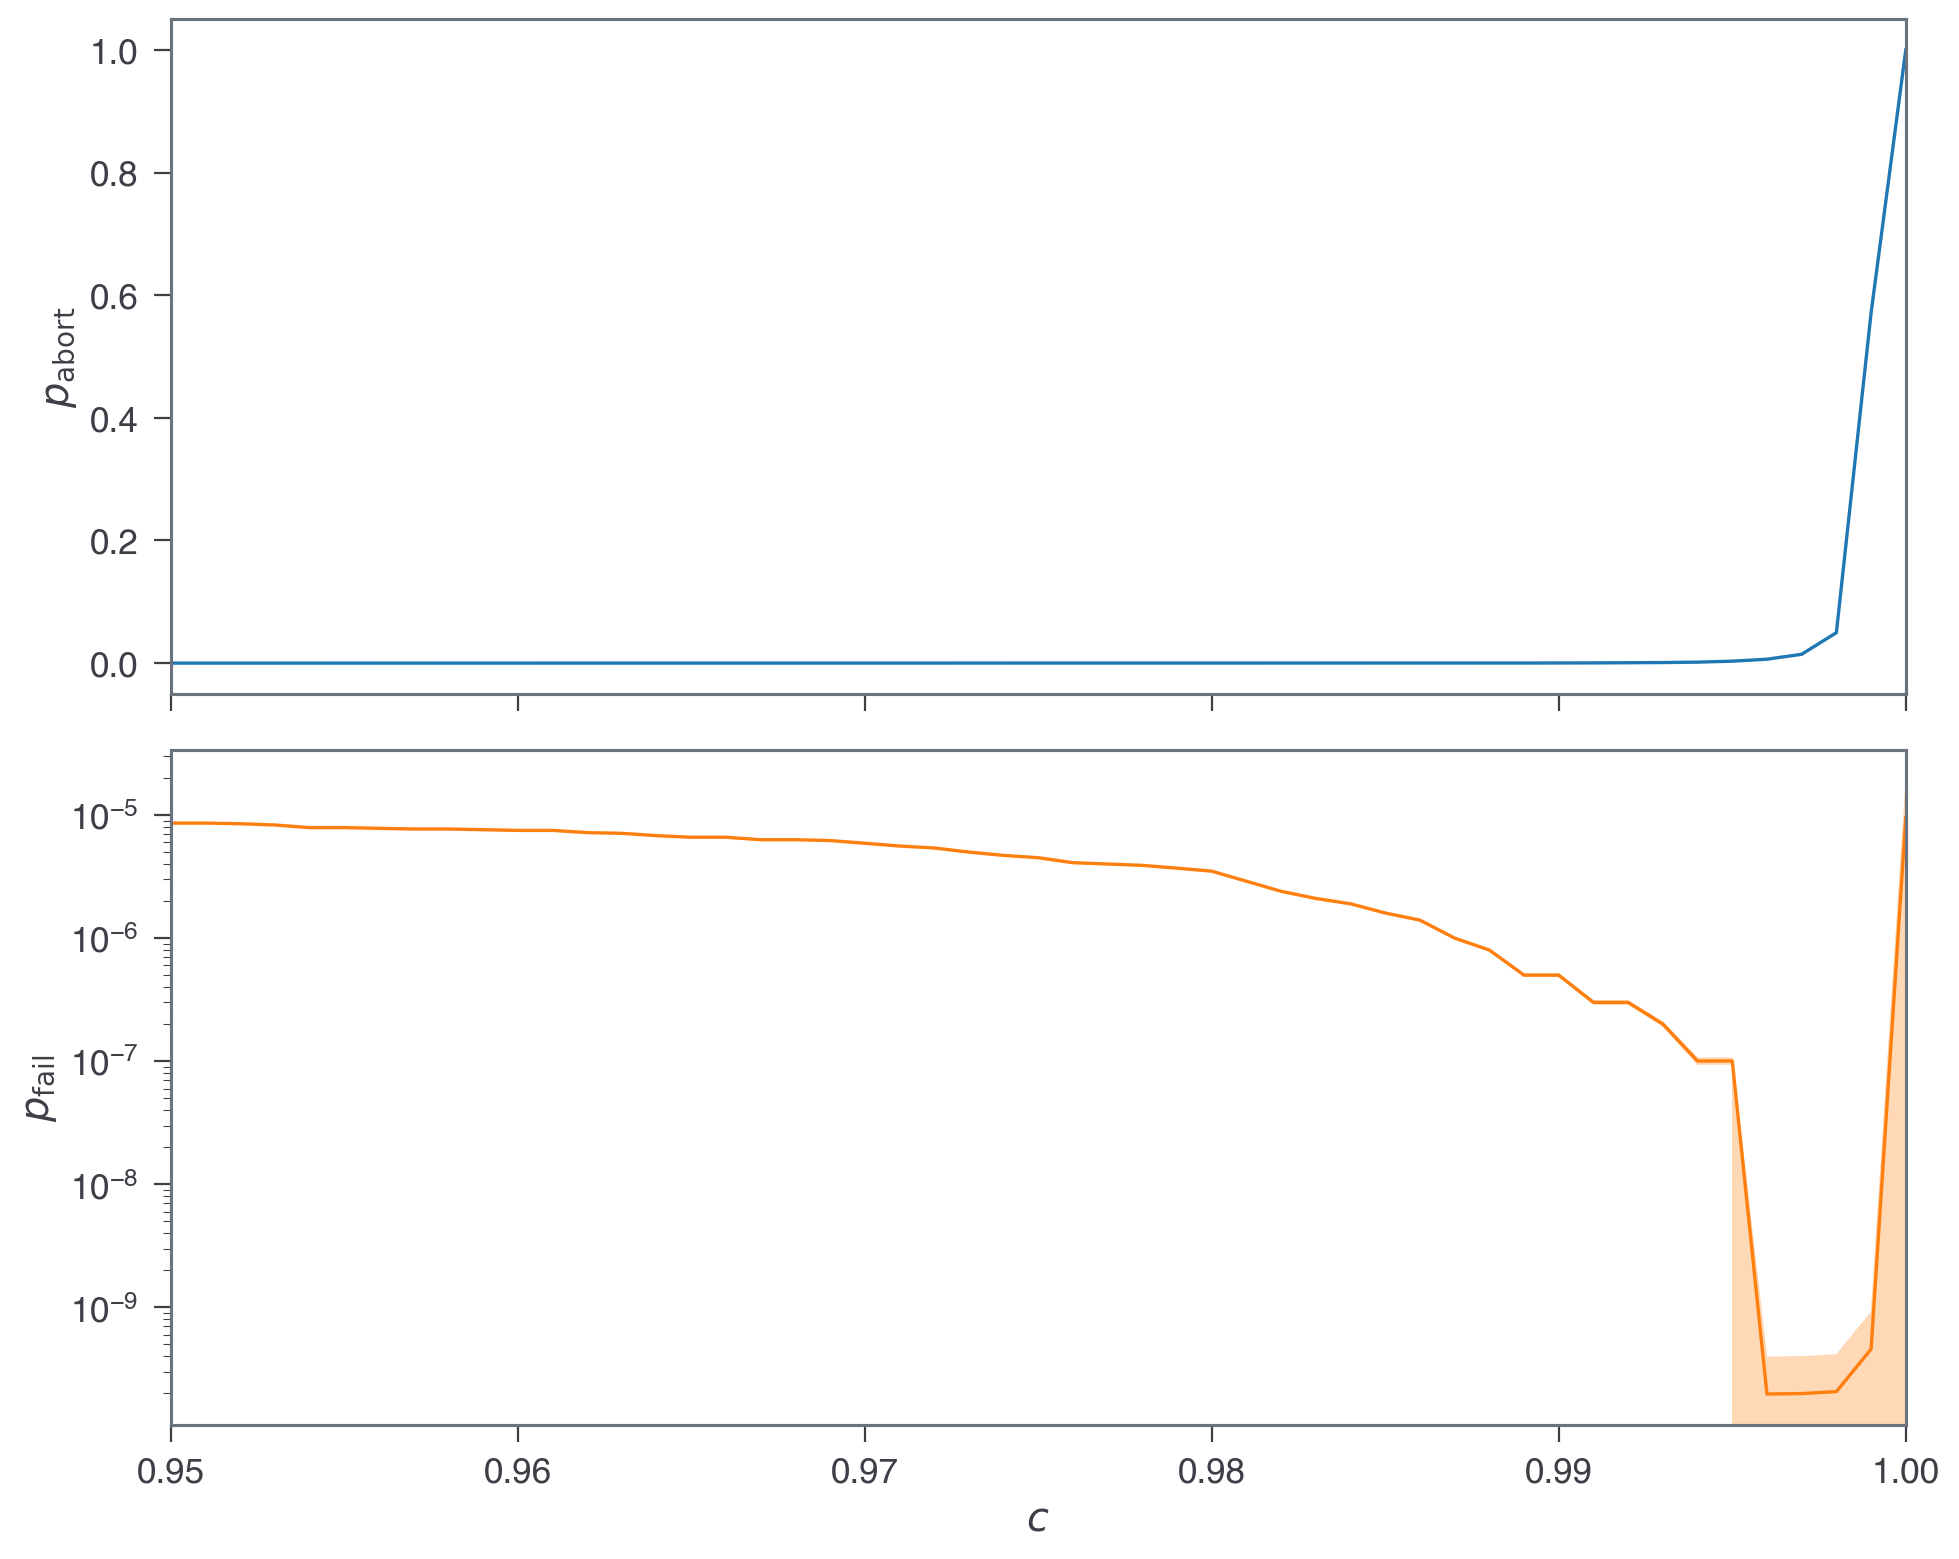

In [21]:
# Create a figure with two subplots (one for p_acc, one for p_fail)
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

color = COLORS(0)
sns.lineplot(
    data=df_ps,
    x="c",
    y="p_abort",
    ax=axes[0],
    color=color,
)
axes[0].fill_between(
    df_ps["c"],
    df_ps["p_abort"] - df_ps["delta_p_abort"],
    df_ps["p_abort"] + df_ps["delta_p_abort"],
    alpha=0.3,
    color=color,
)

color = COLORS(1)
sns.lineplot(data=df_ps, x="c", y="p_fail", ax=axes[1], color=color)
axes[1].fill_between(
    df_ps["c"],
    df_ps["p_fail"] - df_ps["delta_p_fail"],
    df_ps["p_fail"] + df_ps["delta_p_fail"],
    alpha=0.3,
    color=color,
)

# Set titles and labels
axes[0].set_ylabel(r"$p_\mathrm{abort}$")
axes[1].set_xlabel(r"$c$")
axes[1].set_ylabel(r"$p_\mathrm{fail}$")
axes[1].set_yscale("log")

for ax in axes:
    ax.set_xlim(0.95, 1)

# Adjust layout
plt.tight_layout()
plt.show()

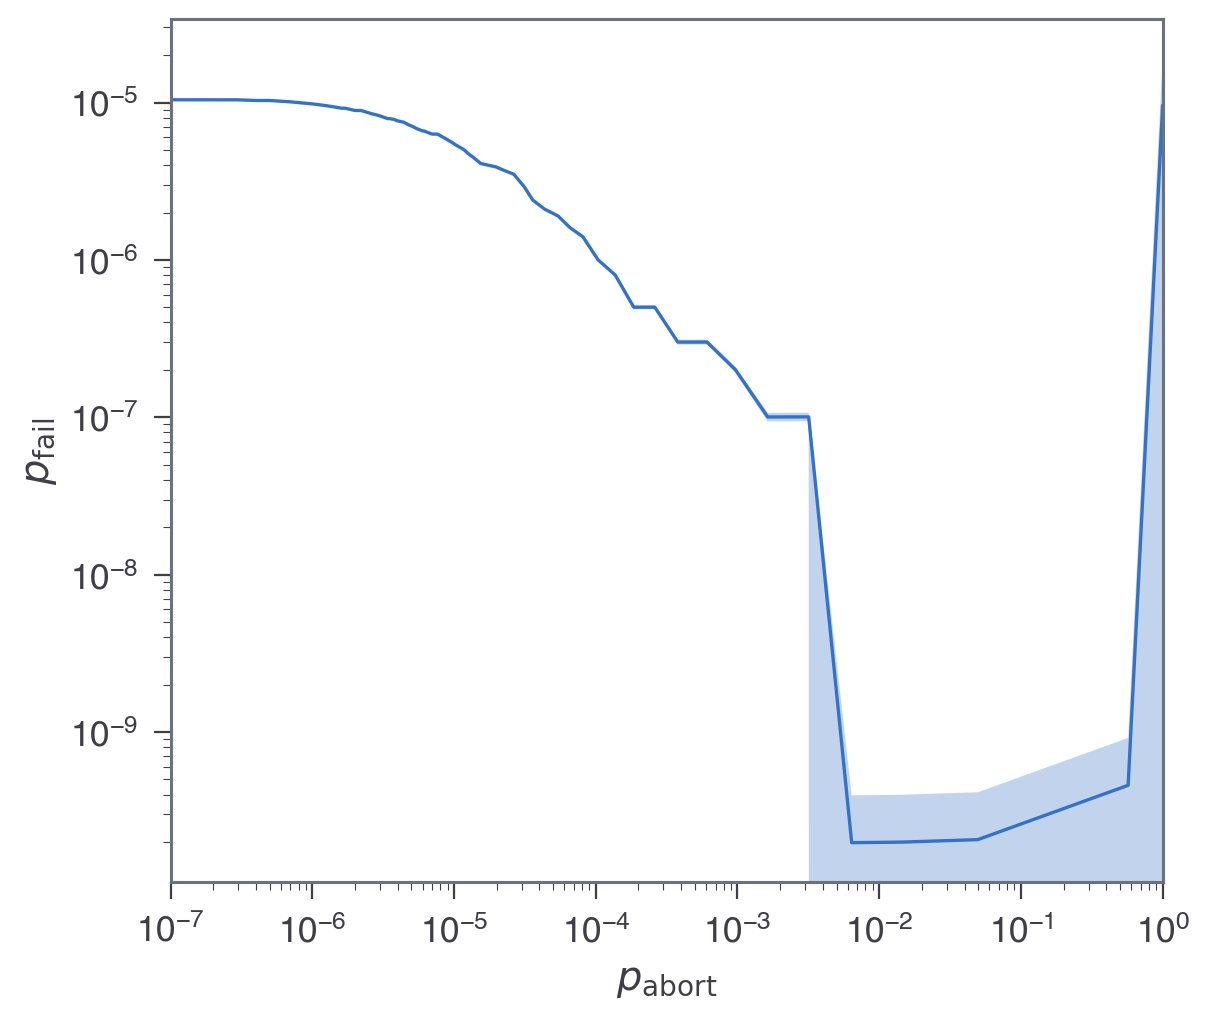

In [20]:
plt.plot(df_ps["p_abort"], df_ps["p_fail"])
plt.fill_between(
    df_ps["p_abort"],
    df_ps["p_fail"] - df_ps["delta_p_fail"],
    df_ps["p_fail"] + df_ps["delta_p_fail"],
    alpha=0.3,
)
plt.xscale("log")
plt.xlim(1e-7, 1)
plt.yscale("log")

plt.xlabel(r"$p_\mathrm{abort}$")
plt.ylabel(r"$p_\mathrm{fail}$")
plt.show()

In [ ]:
from collect_bb_simulation_data import calculate_all_df_ps

df = calculate_all_df_ps()